# Evaluating embedding distances
> Exploring distributions of distances and correlating them to other things we care about

# OTU-level distances

In [2]:
import anndata

# Load the mlrepo
mlrepo = anndata.read_h5ad("../data/mlrepo4.h5ad")
mlrepo

AnnData object with n_obs × n_vars = 10037 × 27105
    obs: 'ravel_black-hispanic', 'ravel_nugent-category', 'ravel_nugent-score', 'ravel_ph', 'ravel_white-black', 'dataset', 'gevers_ileum', 'gevers_pcdai-ileum', 'gevers_pcdai-rectum', 'gevers_rectum', 'sokol_healthy-cd', 'sokol_healthy-uc', 'yatsunenko_baby-age', 'yatsunenko_malawi-venezuela', 'yatsunenko_sex', 'yatsunenko_usa-malawi', 'hmp_gastro-oral', 'hmp_sex', 'hmp_stool-tongue-paired', 'hmp_sub-supragingivalplaque-paired', 'cho_control-ct-cecal', 'cho_control-ct-fecal', 'cho_penicillin-vancomycin-cecal', 'cho_penicillin-vancomycin-fecal', 'turnbaugh_obese-lean-all'
    var: 'k', 'p', 'c', 'o', 'f', 'g', 's', 'fasta'
    obsm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    varm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    obsp: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', '

In [5]:
# Correlations between all distances in varp
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Get all distance matrices from varp
distance_matrices = list(mlrepo.varp.keys())
print(f"Found {len(distance_matrices)} distance matrices in varp: {distance_matrices}")

# Create a dataframe to store correlations between all pairs of distance matrices
correlations = pd.DataFrame(index=distance_matrices, columns=distance_matrices)

# For each pair of distance matrices, compute the correlation
my_tqdm = tqdm(total=int(len(distance_matrices) * (len(distance_matrices) - 1) / 2))
for i, dist1 in enumerate(distance_matrices):
    # for j, dist2 in enumerate(distance_matrices):
    for j in range(i):
        dist2 = distance_matrices[j]
        # Get the distance matrices
        dm1 = mlrepo.varp[dist1]
        dm2 = mlrepo.varp[dist2]

        # Convert to 1D arrays (taking only the upper triangle to avoid redundancy)
        mask = np.triu_indices_from(dm1, k=1)
        dm1_flat = dm1[mask]
        dm2_flat = dm2[mask]

        # Compute correlation
        corr = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
        correlations.loc[dist1, dist2] = corr
        correlations.loc[dist2, dist1] = corr
        my_tqdm.update(1)

Found 16 distance matrices in varp: ['E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s', 'gg_tree_distances']


  0%|          | 0/120 [00:00<?, ?it/s]

In [7]:
# Save results

correlations.to_csv("../results/varp_distance_correlations.csv")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Summary of correlations:
Mean correlation: 0.746
Min correlation: 0.134
Max correlation: 1.000


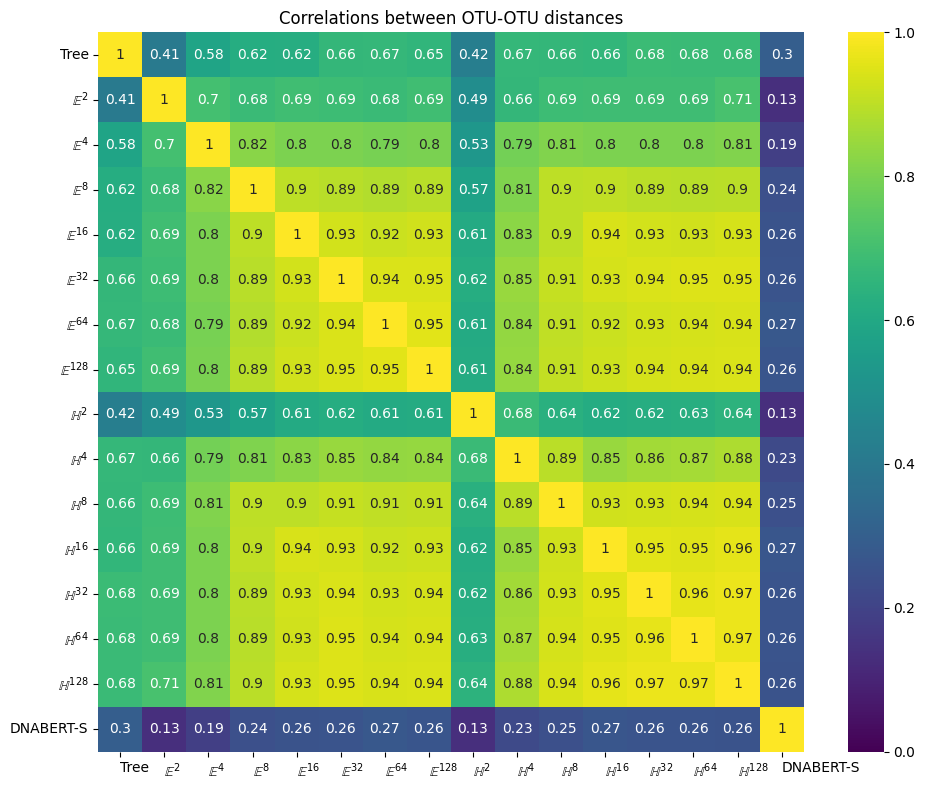

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlations = pd.read_csv("../results/varp_distance_correlations.csv", index_col=0)
# Fix indices
order = [
    ("gg_tree_distances", "Tree"),
    ("E2", "$\\mathbb{E}^2$"),
    ("E4", "$\\mathbb{E}^4$"),
    ("E8", "$\\mathbb{E}^8$"),
    ("E16", "$\\mathbb{E}^{16}$"),
    ("E32", "$\\mathbb{E}^{32}$"),
    ("E64", "$\\mathbb{E}^{64}$"),
    ("E128", "$\\mathbb{E}^{128}$"),
    ("H2", "$\\mathbb{H}^2$"),
    ("H4", "$\\mathbb{H}^4$"),
    ("H8", "$\\mathbb{H}^8$"),
    ("H16", "$\\mathbb{H}^{16}$"),
    ("H32", "$\\mathbb{H}^{32}$"),
    ("H64", "$\\mathbb{H}^{64}$"),
    ("H128", "$\\mathbb{H}^{128}$"),
    ("dnabert-s", "DNABERT-S"),
]
correlations = correlations.loc[[x[0] for x in order], [x[0] for x in order]]

# Zero out lower triangle; drop last empty row and first column
# correlations = correlations.where(np.triu(np.ones(correlations.shape)).astype(bool))
# correlations = correlations.iloc[:-1, 1:]
np.fill_diagonal(correlations.values, 1.0)
correlations = correlations.rename(index=dict(order), columns=dict(order))

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap="viridis", vmin=0, vmax=1, center=0.5)
plt.xticks(rotation=0, ha="left")
plt.yticks(rotation=0, ha="right")
plt.title("Correlations between OTU-OTU distances")
plt.tight_layout()
# plt.show()

# Print summary statistics
print("Summary of correlations:")
print(f"Mean correlation: {correlations.values.mean():.3f}")
print(f"Min correlation: {correlations.values.min():.3f}")
print(f"Max correlation: {correlations.values.max():.3f}")

# Save figure
plt.savefig("../figures/varp_distance_correlations.pdf", bbox_inches="tight", dpi=300)

# Store this plot in the variable "varp_distance_correlations_plot"
varp_distance_correlations_plot = plt.gcf()


# Sample-level distances

In [2]:
import anndata

mlrepo = anndata.read_h5ad("../data/mlrepo4.h5ad")

In [3]:
%%bash

# Compute unifrac with "ssu", which can be found at https://github.com/biocore/unifrac-binaries

export UNIFRAC_GPU_INFO=Y

unifrac_path="/home/phil/miniconda3/envs/unifrac/bin/ssu"
biom_path="../data/mlrepo.biom"
tree_path="../data/greengenes/trees/99_otus.tree"
out_path_unweighted="../results/unweighted_unifrac.tsv"
out_path_weighted="../results/weighted_unifrac.tsv"

echo "starting..."
if [ ! -f $out_path_unweighted.gz ]; then
    $unifrac_path -i $biom_path -o $out_path_unweighted -m unweighted -t $tree_path
    echo "done - unweighted"
    gzip -f $out_path_unweighted
    echo "done - unweighted; gzipped"
fi
if [ ! -f $out_path_weighted.gz ]; then
    $unifrac_path -i $biom_path -o $out_path_weighted -m weighted_normalized -t $tree_path
    echo "done - weighted"
    gzip -f $out_path_weighted
    echo "done - weighted; gzipped"
fi

starting...


gzip: ../results/unweighted_unifrac.tsv.gz already exists;	not overwritten
gzip: ../results/weighted_unifrac.tsv: No such file or directory


CalledProcessError: Command 'b'# Compute unifrac with "ssu", which can be found at https://github.com/biocore/unifrac-binaries\n\nexport UNIFRAC_GPU_INFO=Y\n\nunifrac_path="/home/phil/miniconda3/envs/unifrac/bin/ssu"\nbiom_path="../data/mlrepo.biom"\ntree_path="../data/greengenes/trees/99_otus.tree"\nout_path_unweighted="../results/unweighted_unifrac.tsv"\nout_path_weighted="../results/weighted_unifrac.tsv"\n\necho "starting..."\nif [ ! -f $out_path_unweighted.gz ]; then\n    $unifrac_path -i $biom_path -o $out_path_unweighted -m unweighted -t $tree_path\n    echo "done - unweighted"\nfi\nif [ ! -f $out_path_weighted.gz ]; then\n    $unifrac_path -i $biom_path -o $out_path_weighted -m weighted_normalized -t $tree_path\n    echo "done - weighted"\nfi\n\ngzip $out_path_unweighted\ngzip $out_path_weighted\n'' returned non-zero exit status 1.

In [3]:
# Add distance matrices to mlrepo
import pandas as pd

for metric in ["unweighted_unifrac", "weighted_unifrac"]:
    dists = pd.read_table(f"../results/{metric}.tsv.gz", sep="\t", index_col=0)
    dists = dists.loc[mlrepo.obs.index, mlrepo.obs.index]
    mlrepo.obsp[metric] = dists.values

In [4]:
mlrepo.write_h5ad("../data/mlrepo5.h5ad")

In [ ]:
import anndata
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix

mlrepo = anndata.read_h5ad("../data/mlrepo5.h5ad")

for metric in [
    "braycurtis",
    # "jaccard",
    "manhattan",
    # "jensenshannon"
]:
    print(f"Computing {metric} distance matrix")
    dists = pairwise_distances(mlrepo.X, metric=metric, n_jobs=-1)
    mlrepo.obsp[metric] = dists
    del dists

for metric in ["euclidean", "cosine"]:
    print(f"Computing {metric} distance matrix")
    dists = pairwise_distances(mlrepo.X, metric=metric, n_jobs=1)  # They're already parallelized on the backend
    mlrepo.obsp[metric] = dists
    del dists

Computing euclidean distance matrix
Computing cosine distance matrix


In [3]:
# Save results
mlrepo.write_h5ad("../data/mlrepo5.h5ad")
mlrepo

AnnData object with n_obs × n_vars = 10037 × 27105
    obs: 'ravel_black-hispanic', 'ravel_nugent-category', 'ravel_nugent-score', 'ravel_ph', 'ravel_white-black', 'dataset', 'gevers_ileum', 'gevers_pcdai-ileum', 'gevers_pcdai-rectum', 'gevers_rectum', 'sokol_healthy-cd', 'sokol_healthy-uc', 'yatsunenko_baby-age', 'yatsunenko_malawi-venezuela', 'yatsunenko_sex', 'yatsunenko_usa-malawi', 'hmp_gastro-oral', 'hmp_sex', 'hmp_stool-tongue-paired', 'hmp_sub-supragingivalplaque-paired', 'cho_control-ct-cecal', 'cho_control-ct-fecal', 'cho_penicillin-vancomycin-cecal', 'cho_penicillin-vancomycin-fecal', 'turnbaugh_obese-lean-all'
    var: 'k', 'p', 'c', 'o', 'f', 'g', 's', 'fasta'
    obsm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    varm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    obsp: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', '

# Correlations - sample-level distances

In [1]:
import anndata

mlrepo = anndata.read_h5ad("../data/mlrepo5.h5ad")

In [5]:
# Correlations
import pandas as pd
import numpy as np
import anndata
from tqdm.notebook import tqdm

# Get all distance matrices from varp
distance_matrices = list(mlrepo.obsp.keys())
print(f"Found {len(distance_matrices)} distance matrices in obsp: {distance_matrices}")

# Create a dataframe to store correlations between all pairs of distance matrices
correlations = pd.DataFrame(index=distance_matrices, columns=distance_matrices)

# For each pair of distance matrices, compute the correlation
my_tqdm = tqdm(total=int(len(distance_matrices) * (len(distance_matrices) - 1) / 2))
for i, dist1 in enumerate(distance_matrices):
    # for j, dist2 in enumerate(distance_matrices):
    for j in range(i):
        dist2 = distance_matrices[j]
        # Get the distance matrices
        dm1 = mlrepo.obsp[dist1]
        dm2 = mlrepo.obsp[dist2]

        # Convert to 1D arrays (taking only the upper triangle to avoid redundancy)
        mask = np.triu_indices_from(dm1, k=1)
        dm1_flat = dm1[mask]
        dm2_flat = dm2[mask]

        # Compute correlation
        corr = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
        correlations.loc[dist1, dist2] = corr
        correlations.loc[dist2, dist1] = corr
        my_tqdm.update(1)

Found 21 distance matrices in obsp: ['E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s', 'unweighted_unifrac', 'weighted_unifrac', 'braycurtis', 'manhattan', 'euclidean', 'cosine']


  0%|          | 0/210 [00:00<?, ?it/s]

In [7]:
# Save results

correlations.to_csv("../results/obsp_distance_correlations.csv")

Summary of correlations:
Mean correlation: 0.735
Min correlation: 0.183
Max correlation: 1.000


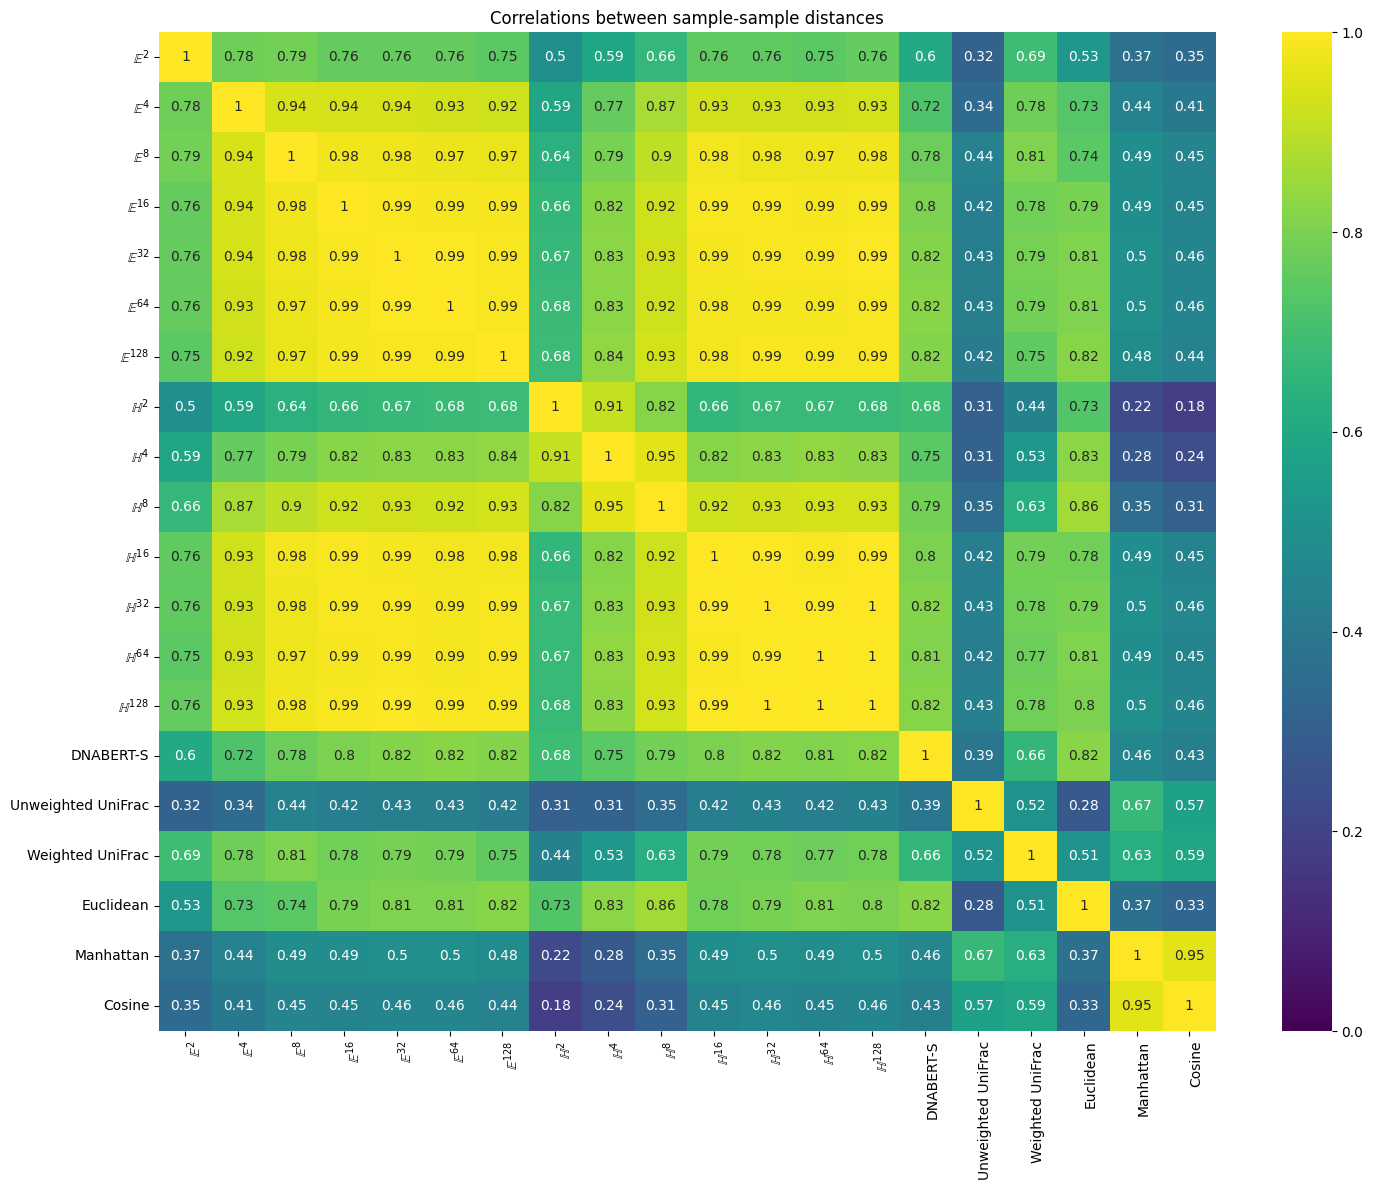

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

correlations = pd.read_csv("../results/obsp_distance_correlations.csv", index_col=0)
# Fix indices
order = [
    ("E2", "$\\mathbb{E}^2$"),
    ("E4", "$\\mathbb{E}^4$"),
    ("E8", "$\\mathbb{E}^8$"),
    ("E16", "$\\mathbb{E}^{16}$"),
    ("E32", "$\\mathbb{E}^{32}$"),
    ("E64", "$\\mathbb{E}^{64}$"),
    ("E128", "$\\mathbb{E}^{128}$"),
    ("H2", "$\\mathbb{H}^2$"),
    ("H4", "$\\mathbb{H}^4$"),
    ("H8", "$\\mathbb{H}^8$"),
    ("H16", "$\\mathbb{H}^{16}$"),
    ("H32", "$\\mathbb{H}^{32}$"),
    ("H64", "$\\mathbb{H}^{64}$"),
    ("H128", "$\\mathbb{H}^{128}$"),
    ("dnabert-s", "DNABERT-S"),
    ("unweighted_unifrac", "Unweighted UniFrac"),
    ("weighted_unifrac", "Weighted UniFrac"),
    ("euclidean", "Euclidean"),
    ("manhattan", "Manhattan"),
    ("cosine", "Cosine"),
    # ("braycurtis", "Bray-Curtis"),
]
correlations = correlations.loc[[x[0] for x in order], [x[0] for x in order]]

# Zero out lower triangle; drop last empty row and first column
# correlations = correlations.where(np.triu(np.ones(correlations.shape)).astype(bool))
# correlations = correlations.iloc[:-1, 1:]
# Set diagonal to 1.
# Set diagonal to 1 by filling the diagonal of the numpy array
np.fill_diagonal(correlations.values, 1.0)

correlations = correlations.rename(index=dict(order), columns=dict(order))

# Visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlations, annot=True, cmap="viridis", vmin=0, vmax=1, center=0.5)
plt.xticks(rotation=90, ha="left")
plt.yticks(rotation=0, ha="right")
plt.title("Correlations between sample-sample distances")
plt.tight_layout()
# plt.show()

# Print summary statistics
print("Summary of correlations:")
print(f"Mean correlation: {correlations.values.mean():.3f}")
print(f"Min correlation: {correlations.values.min():.3f}")
print(f"Max correlation: {correlations.values.max():.3f}")

# Save figure
plt.savefig("../figures/obsp_distance_correlations.pdf", bbox_inches="tight", dpi=300)

# Store this plot in the variable "obsp_distance_correlations_plot"
obsp_distance_correlations_plot = plt.gcf()


# Combined figure

/tmp/ipykernel_552886/3512112675.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make room for the colorbar


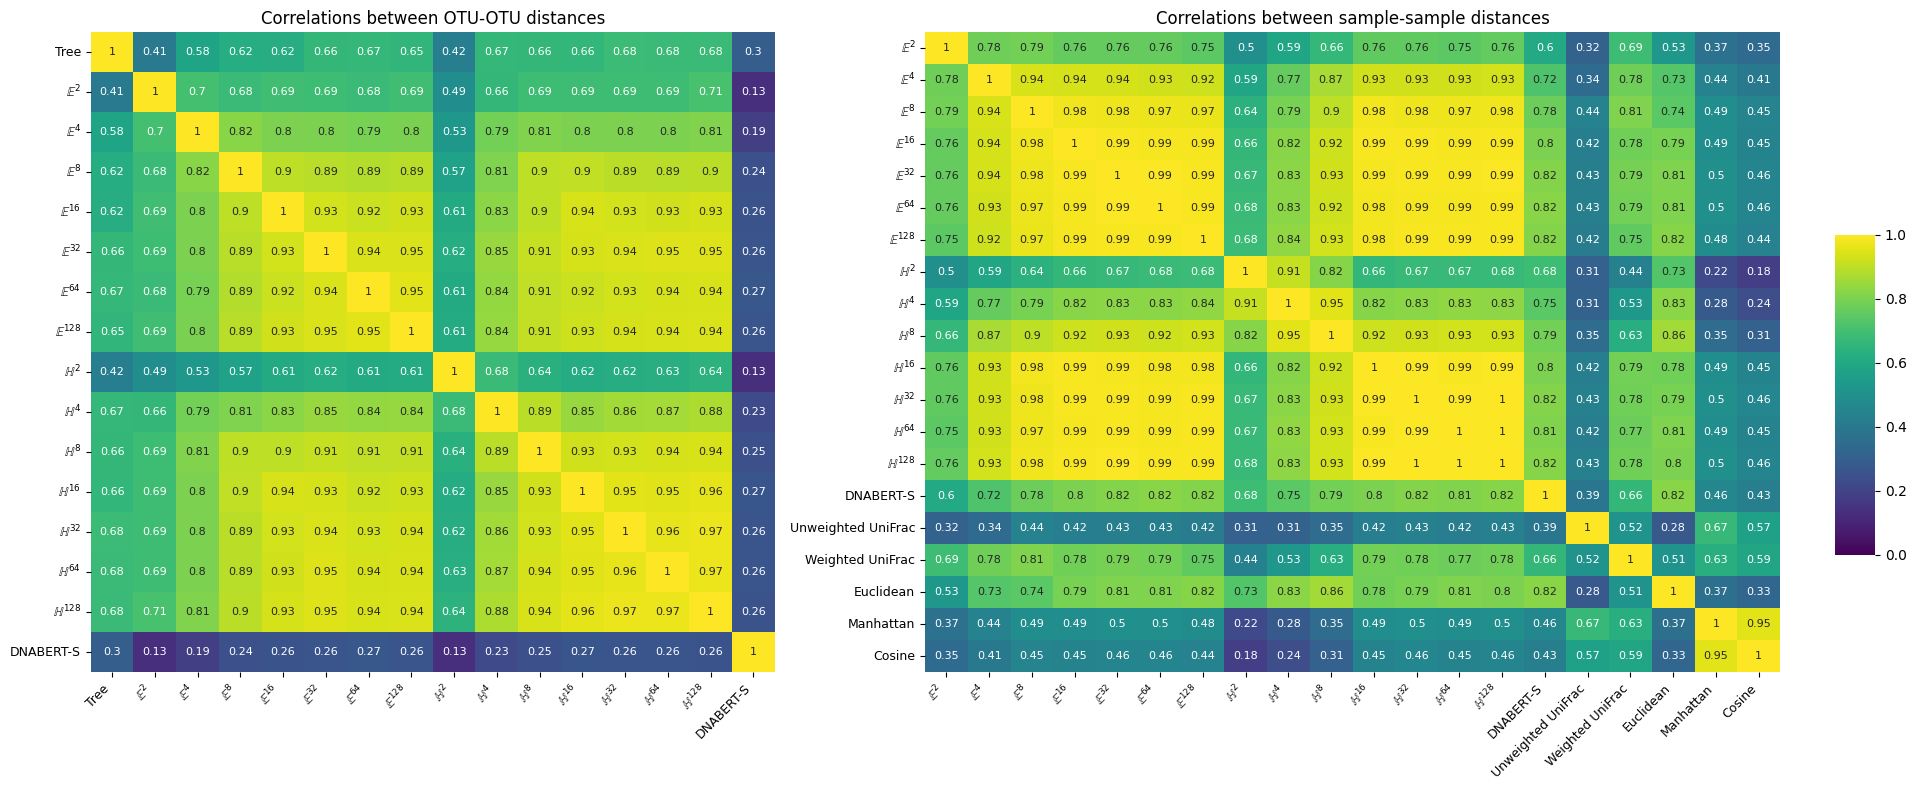

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# Load and process the first correlation matrix
correlations_varp = pd.read_csv("../results/varp_distance_correlations.csv", index_col=0)
order_varp = [
    ("gg_tree_distances", "Tree"),
    ("E2", "$\\mathbb{E}^2$"),
    ("E4", "$\\mathbb{E}^4$"),
    ("E8", "$\\mathbb{E}^8$"),
    ("E16", "$\\mathbb{E}^{16}$"),
    ("E32", "$\\mathbb{E}^{32}$"),
    ("E64", "$\\mathbb{E}^{64}$"),
    ("E128", "$\\mathbb{E}^{128}$"),
    ("H2", "$\\mathbb{H}^2$"),
    ("H4", "$\\mathbb{H}^4$"),
    ("H8", "$\\mathbb{H}^8$"),
    ("H16", "$\\mathbb{H}^{16}$"),
    ("H32", "$\\mathbb{H}^{32}$"),
    ("H64", "$\\mathbb{H}^{64}$"),
    ("H128", "$\\mathbb{H}^{128}$"),
    ("dnabert-s", "DNABERT-S"),
]
correlations_varp = correlations_varp.loc[[x[0] for x in order_varp], [x[0] for x in order_varp]]
np.fill_diagonal(correlations_varp.values, 1.0)
correlations_varp = correlations_varp.rename(index=dict(order_varp), columns=dict(order_varp))

# Load and process the second correlation matrix
correlations_obsp = pd.read_csv("../results/obsp_distance_correlations.csv", index_col=0)
order_obsp = [
    ("E2", "$\\mathbb{E}^2$"),
    ("E4", "$\\mathbb{E}^4$"),
    ("E8", "$\\mathbb{E}^8$"),
    ("E16", "$\\mathbb{E}^{16}$"),
    ("E32", "$\\mathbb{E}^{32}$"),
    ("E64", "$\\mathbb{E}^{64}$"),
    ("E128", "$\\mathbb{E}^{128}$"),
    ("H2", "$\\mathbb{H}^2$"),
    ("H4", "$\\mathbb{H}^4$"),
    ("H8", "$\\mathbb{H}^8$"),
    ("H16", "$\\mathbb{H}^{16}$"),
    ("H32", "$\\mathbb{H}^{32}$"),
    ("H64", "$\\mathbb{H}^{64}$"),
    ("H128", "$\\mathbb{H}^{128}$"),
    ("dnabert-s", "DNABERT-S"),
    ("unweighted_unifrac", "Unweighted UniFrac"),
    ("weighted_unifrac", "Weighted UniFrac"),
    ("euclidean", "Euclidean"),
    ("manhattan", "Manhattan"),
    ("cosine", "Cosine"),
]
correlations_obsp = correlations_obsp.loc[[x[0] for x in order_obsp], [x[0] for x in order_obsp]]
np.fill_diagonal(correlations_obsp.values, 1.0)
correlations_obsp = correlations_obsp.rename(index=dict(order_obsp), columns=dict(order_obsp))

# Calculate the width ratio based on the number of entries in each matrix
varp_size = len(correlations_varp)
obsp_size = len(correlations_obsp)
width_ratio = [varp_size, obsp_size]

# Create a figure with two subplots with proportional widths
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=width_ratio)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Plot the first heatmap - no colorbar since it's the same as the second
sns.heatmap(correlations_varp, annot=True, cmap="viridis", vmin=0, vmax=1, center=0.5, ax=ax1, cbar=False, 
            annot_kws={"size": 8})
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, ha="right", fontsize=9)
ax1.set_title("Correlations between OTU-OTU distances")

# Plot the second heatmap
cbar_ax = fig.add_axes([.92, .3, .02, .4])  # Position for colorbar
sns.heatmap(correlations_obsp, annot=True, cmap="viridis", vmin=0, vmax=1, center=0.5, ax=ax2, 
            cbar_ax=cbar_ax, annot_kws={"size": 8})
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, ha="right", fontsize=9)
ax2.set_title("Correlations between sample-sample distances")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make room for the colorbar

# Save the combined figure
plt.savefig("../figures/combined_distance_correlations.pdf", bbox_inches="tight", dpi=300)

# Show the combined figure
plt.show()


In [46]:
import anndata

mlrepo = anndata.read_h5ad("../data/mlrepo5.h5ad")

Refined visualization with MDS embeddings created successfully!


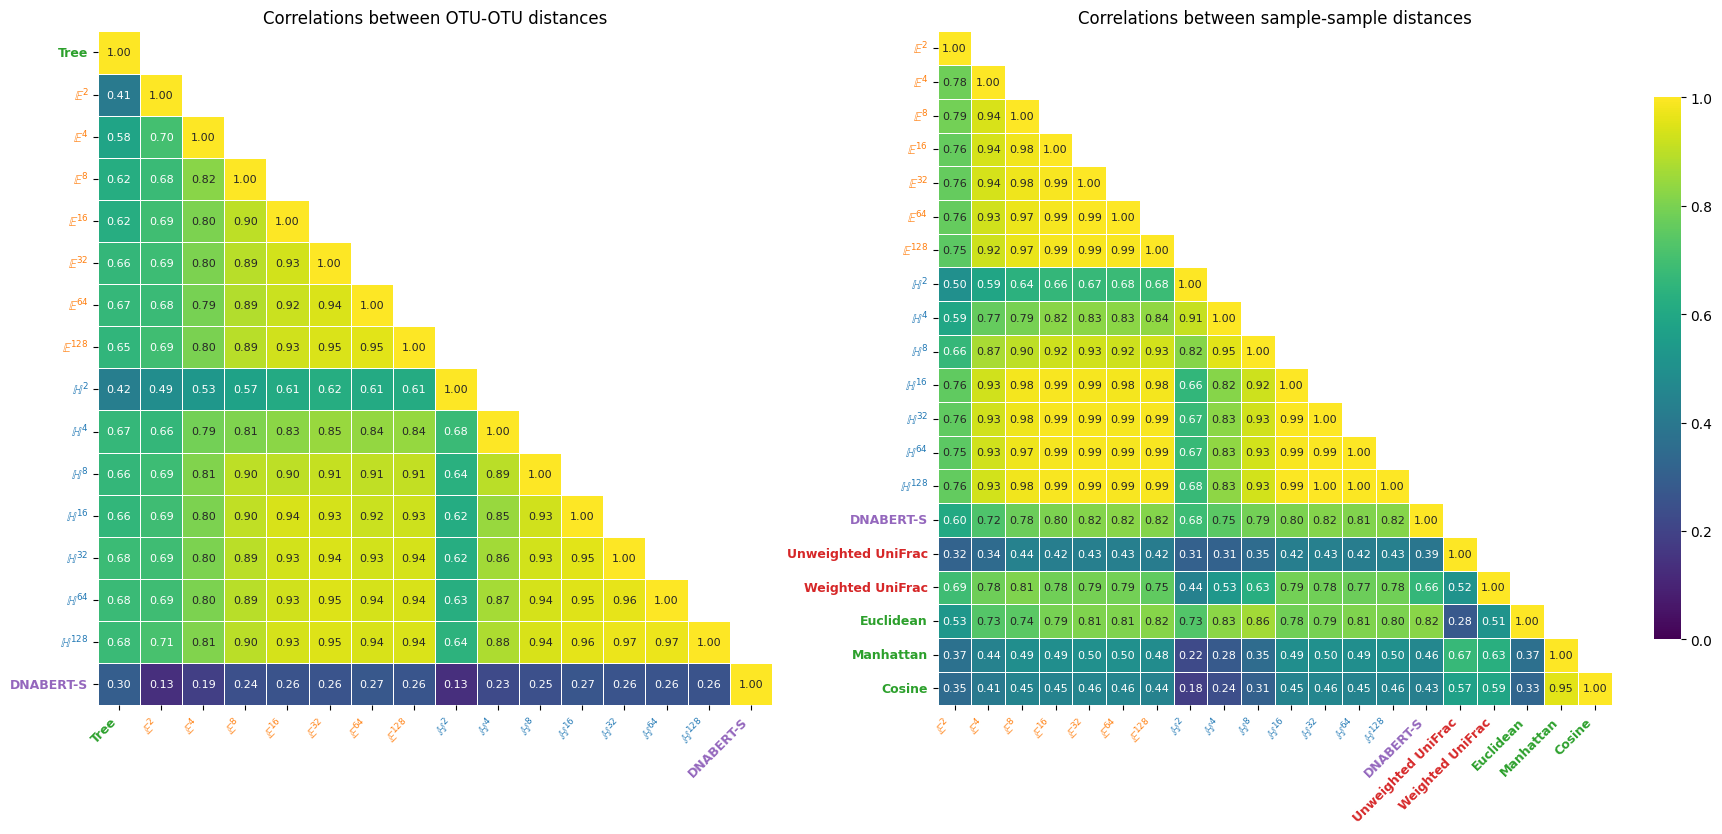

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform

# Load and process the matrices (using your existing code)
correlations_varp = pd.read_csv("../results/varp_distance_correlations.csv", index_col=0)
order_varp = [
    ("gg_tree_distances", "Tree"),
    ("E2", "$\\mathbb{E}^2$"),
    ("E4", "$\\mathbb{E}^4$"),
    ("E8", "$\\mathbb{E}^8$"),
    ("E16", "$\\mathbb{E}^{16}$"),
    ("E32", "$\\mathbb{E}^{32}$"),
    ("E64", "$\\mathbb{E}^{64}$"),
    ("E128", "$\\mathbb{E}^{128}$"),
    ("H2", "$\\mathbb{H}^2$"),
    ("H4", "$\\mathbb{H}^4$"),
    ("H8", "$\\mathbb{H}^8$"),
    ("H16", "$\\mathbb{H}^{16}$"),
    ("H32", "$\\mathbb{H}^{32}$"),
    ("H64", "$\\mathbb{H}^{64}$"),
    ("H128", "$\\mathbb{H}^{128}$"),
    ("dnabert-s", "DNABERT-S"),
]

correlations_varp = correlations_varp.loc[[x[0] for x in order_varp], [x[0] for x in order_varp]]
np.fill_diagonal(correlations_varp.values, 1.0)
correlations_varp = correlations_varp.rename(index=dict(order_varp), columns=dict(order_varp))

# Load and process the second correlation matrix
correlations_obsp = pd.read_csv("../results/obsp_distance_correlations.csv", index_col=0)
order_obsp = [
    ("E2", "$\\mathbb{E}^2$"),
    ("E4", "$\\mathbb{E}^4$"),
    ("E8", "$\\mathbb{E}^8$"),
    ("E16", "$\\mathbb{E}^{16}$"),
    ("E32", "$\\mathbb{E}^{32}$"),
    ("E64", "$\\mathbb{E}^{64}$"),
    ("E128", "$\\mathbb{E}^{128}$"),
    ("H2", "$\\mathbb{H}^2$"),
    ("H4", "$\\mathbb{H}^4$"),
    ("H8", "$\\mathbb{H}^8$"),
    ("H16", "$\\mathbb{H}^{16}$"),
    ("H32", "$\\mathbb{H}^{32}$"),
    ("H64", "$\\mathbb{H}^{64}$"),
    ("H128", "$\\mathbb{H}^{128}$"),
    ("dnabert-s", "DNABERT-S"),
    ("unweighted_unifrac", "Unweighted UniFrac"),
    ("weighted_unifrac", "Weighted UniFrac"),
    ("euclidean", "Euclidean"),
    ("manhattan", "Manhattan"),
    ("cosine", "Cosine"),
]

correlations_obsp = correlations_obsp.loc[[x[0] for x in order_obsp], [x[0] for x in order_obsp]]
np.fill_diagonal(correlations_obsp.values, 1.0)
correlations_obsp = correlations_obsp.rename(index=dict(order_obsp), columns=dict(order_obsp))

# Define metric types and their colors
def get_metric_type_and_color(label):
    if '$\\mathbb{H}' in label:
        return 'Hyperbolic', 'C0'  # blue
    elif '$\\mathbb{E}' in label:
        return 'Euclidean', 'C1'   # orange
    elif 'Tree' in label:
        return 'Tree', 'C2'        # green
    elif 'UniFrac' in label:
        return 'UniFrac', 'C3'     # red
    elif 'DNABERT' in label:
        return 'DNABERT-S', 'C4'   # purple
    elif label in ['Euclidean', 'Manhattan', 'Cosine']:
        return 'Distances', 'C2'   # green
    else:
        return 'Other', 'gray'

# Create a figure with carefully crafted aesthetics
fig = plt.figure(figsize=(18, 8))

# Create a grid with proper proportions
gs = gridspec.GridSpec(1, 2, width_ratios=[len(correlations_varp), len(correlations_obsp)])

# Create lower triangular masks for the heatmaps
mask_varp = np.triu(np.ones_like(correlations_varp), k=1)
mask_obsp = np.triu(np.ones_like(correlations_obsp), k=1)

# Create the heatmap subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Plot the heatmaps with triangular masks (lower triangle)
sns.heatmap(correlations_varp, mask=mask_varp, cmap="viridis", 
           vmin=0, vmax=1, square=True, linewidths=0.5, ax=ax1,
           cbar=False, annot=True, fmt='.2f', annot_kws={"size": 8})

# Second heatmap with colorbar
sns.heatmap(correlations_obsp, mask=mask_obsp, cmap="viridis",
           vmin=0, vmax=1, square=True, linewidths=0.5, ax=ax2,
           cbar_kws={"shrink": 0.8}, 
           annot=True, fmt='.2f', annot_kws={"size": 8})

# Color the tick labels according to metric type
def color_tick_labels(ax, labels):
    """Color the tick labels based on metric type"""
    for i, label in enumerate(labels):
        metric_type, color = get_metric_type_and_color(label)
        
        # Color x tick labels
        ax.get_xticklabels()[i].set_color(color)
        
        # Color y tick labels
        ax.get_yticklabels()[i].set_color(color)

# Apply rotations and colors to tick labels
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9, weight="bold")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=9, weight="bold")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9, weight="bold")
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=9, weight="bold")

# Color the tick labels
color_tick_labels(ax1, correlations_varp.index)
color_tick_labels(ax2, correlations_obsp.index)

# Add basic titles
ax1.set_title("Correlations between OTU-OTU distances", fontsize=12)
ax2.set_title("Correlations between sample-sample distances", fontsize=12)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("../figures/correlation_matrix_mds.pdf", bbox_inches="tight", dpi=300)

print("Refined visualization with MDS embeddings created successfully!")